In [1]:
import os
import torch
import pandas as pd
import numpy as np
import cv2
import glob
import random
from tqdm.notebook import tqdm

In [ ]:
!git clone https://github.com/HongguLiu/Deepfake-Detection
!pip install pretrainedmodels==0.7.4

Cloning into 'Deepfake-Detection'...
remote: Enumerating objects: 108, done.
remote: Counting objects: 100% (67/67), done.
remote: Compressing objects: 100% (65/65), done.
remote: Total 108 (delta 34), reused 6 (delta 2), pack-reused 41
Receiving objects: 100% (108/108), 129.93 MiB | 25.69 MiB/s, done.
Resolving deltas: 100% (44/44), done.
     |████████████████████████████████| 61kB 7.0MB/s 
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-cp37-none-any.whl size=60966 sha256=b8c0d78c626a53094f68951cb6f0352e26e7c6ef0ea133f4d7f7a5698b26cb0c
  Stored in directory: /root/.cache/pip/wheels/69/df/63/62583c096289713f22db605aa2334de5b591d59861a02c2ecd
Successfully built pretrainedmodels


In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3MB 13.8MB/s 


In [ ]:
import sys
sys.path.insert(0, "/content/Deepfake-Detection/network")
sys.path.insert(1,'/content/Deepfake-Detection')

In [ ]:
def videoReader(path,n_frames=10,SAVE_DIR=None,detector = None):
    v_cap = cv2.VideoCapture(path)
    v_len = int(v_cap.get(cv2.CAP_PROP_FRAME_COUNT)) 
    fourcc = cv2.VideoWriter_fourcc(*'MJPG')

        # Pick 'n_frames' evenly spaced frames to sample
    if n_frames is None:
        sample = np.arange(0, v_len)
    else:
        sample = np.linspace(0, v_len - 1, n_frames).astype(int)
    face_detector = detector()
    filename = path.split('/')[-1]
    # Loop through frames
    faces = []
    frames = []
    for j in range(v_len):
        success = v_cap.grab()
        if j in sample:
            # Load frame
            #cv2.VideoCapture.retrieve() : grab한 frame을 decode해서 반환
            success, frame = v_cap.retrieve()
            if not success:
                continue
            #frame = cv2.resize(frame,(240,240))
            frames.append(frame)
            face = face_detector.detect_faces(frame)
            if len(face) == 0 : continue
            print(face)
            size = int(face[0]['box'][2] * face[0]['box'][3])
            faces.append((face,size,frame))

    if len(faces) != 0 :
      sorted(faces,key=lambda face: face[1])

      img = faces[0]
      x, y, width, height= img[0][0]['box']
      cropped_face = (img[2])[y:y+height, x:x+width]
      filename = filename.split('.')[0]
      cv2.imwrite(SAVE_DIR + filename +'.jpg',cropped_face)

In [ ]:
TRAIN_DIR = '/content/drive/MyDrive/2021Hanium_deepfakeDetectionApplication/test_videos/'
SAVE_DIR = '/content/drive/MyDrive/2021Hanium_deepfakeDetectionApplication/Kim_jeeyoung_folder/deepfake-detection-challenge/test_images/'
folders = os.listdir(TRAIN_DIR)

In [ ]:
from mtcnn import MTCNN
all_test_videos = glob.glob(os.path.join(TRAIN_DIR, '*.mp4'))
for path in tqdm(all_test_videos):
    videoReader(path,10,SAVE_DIR,MTCNN)

In [ ]:
model_path = '/content/drive/MyDrive/2021Hanium_deepfakeDetectionApplication/Kim_jeeyoung_folder/model/firstXceptionRunModel/train_2/xception_weights_best.pth'

In [ ]:
model_path2 = '/content/drive/MyDrive/2021Hanium_deepfakeDetectionApplication/faceforensics++_models/faceforensics++_models_subset/full/xception/full_raw.p'

In [ ]:
from dataset.transform import xception_default_data_transforms

def preprocess_image(image, cuda=True):
    """
    Preprocesses the image such that it can be fed into our network.
    During this process we envoke PIL to cast it into a PIL image.
    :param image: numpy image in opencv form (i.e., BGR and of shape
    :return: pytorch tensor of shape [1, 3, image_size, image_size], not
    necessarily casted to cuda
    """
    # Revert from BGR
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    # Preprocess using the preprocessing function used during training and
    # casting it to PIL image
    preprocess = xception_default_data_transforms['test']
    preprocessed_image = preprocess(pil_image.fromarray(image))
    # Add first dimension as the network expects a batch
    preprocessed_image = preprocessed_image.unsqueeze(0)
    if cuda:
        preprocessed_image = preprocessed_image.cuda()
    return preprocessed_image

In [ ]:
import os
import argparse
from os.path import join
import cv2
import dlib
import torch
import torch.nn as nn
from PIL import Image as pil_image
from tqdm import tqdm
from network.models import model_selection

def predict_with_model(image, model, post_function=nn.Softmax(dim=1),cuda=True):
    """
    Predicts the label of an input image. Preprocesses the input image and
    casts it to cuda if required
    """
    # Preprocess
    preprocessed_image = preprocess_image(image, cuda)

    # Model prediction
    output = model(preprocessed_image)
    output = post_function(output)

    # Cast to desired
    pred_num, prediction = torch.max(output, 1)    # argmax
    prediction = float(prediction.cpu().numpy())
    pred_num = float(pred_num.cpu().detach().numpy())

    return pred_num, int(prediction), output

In [ ]:
from network.models import model_selection
model = model_selection(modelname='xception', num_out_classes=2, dropout=0.5)
model = torch.load(model_path2)
#model.load_state_dict(torch.load(model_path))
#model = torch.load(model_path)
if isinstance(model, torch.nn.DataParallel):
	model = model.module
model = model.cuda()

Using dropout 0.5


/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'network.models.TransferModel' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'pretrainedmodels.models.xception.Xception' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/usr/local/lib/python3.7/dist-packages/torch/serialization.py:671: SourceChangeWarning: source code of class 'torch.nn.modules.conv.Conv2d' has changed. you can retrieve the original source code by accessing the object's source attribute or set 

RuntimeError: ignored

In [ ]:
all_test_images = glob.glob(os.path.join(SAVE_DIR, '*.jpg'))

In [ ]:
image = cv2.imread(all_test_images[9],cv2.IMREAD_COLOR)

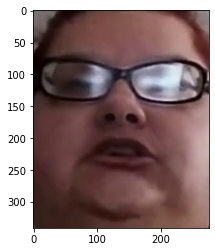

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.show()

In [ ]:
prob, prediction, output = predict_with_model(image,model,cuda=True)

In [ ]:
prob

0.987860381603241

In [ ]:
prediction

0

In [ ]:
output

tensor([[0.5163, 0.4837]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [ ]:
submission = []

for path in tqdm(all_test_images):
  image = cv2.imread(path,cv2.IMREAD_COLOR)
  filename = path.split('/')[-1]

  prob, prediction, output = predict_with_model(image,model,cuda=True)
  if prob is not None :
    y_pred = prob
  else:
    y_pred = 0.5

  submission.append([filename, y_pred])

100%|██████████| 389/389 [00:05<00:00, 74.15it/s]


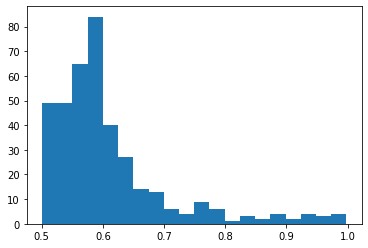

In [ ]:
submission = pd.DataFrame(submission, columns=['filename', 'label'])
plt.hist(submission.label, 20)
plt.show()

In [ ]:
from PIL import Image
from torch.utils.data import Dataset
import os
import random


class myDataset(Dataset):
    def __init__(self, test_list, transform=None, target_transform=None):
        #fh = open(txt_path, 'r')
        imgs = []
        label = None
        for path in tqdm(test_list):
          imgs.append((path,label))
 
        self.imgs = imgs
        self.transform = transform
        self.target_transform = target_transform

    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = Image.open(fn).convert('RGB')

        if self.transform is not None:
            img = self.transform(img)

        return img, label
    
    def getPath(self,index):
      return (self.imgs[index])[0]

    def __len__(self):
        return len(self.imgs)

In [ ]:
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import DataLoader
import torch.optim as optim
from torch.optim import lr_scheduler
import argparse
import os
import cv2

def test(output_name='xception_weights',test=[],meta = None, epoches = 20,batch_size = 32,  model_path=None):
  torch.backends.cudnn.benchmark = True
  test_dataset = MyDataSet(test_list = test,transform = xception_default_data_transforms['test'])
  test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True, num_workers=8)
  test_dataset_size = len(test_dataset)
  corrects = 0
  acc = 0
	#model = torchvision.models.densenet121(num_classes=2)
  model = model_selection(modelname='xception', num_out_classes=2, dropout=0.5)
  model.load_state_dict(torch.load(model_path))
  if isinstance(model, torch.nn.DataParallel):
    model = model.module
  model = model.cuda()
  model.eval()
  with torch.no_grad():
    for (image, labels) in test_loader:
      image = image.cuda()
      labels = labels.cuda()
      outputs = model(image)
      _, preds = torch.max(outputs.data, 1)
      corrects += torch.sum(preds == labels.data).to(torch.float32)
      print('Iteration Acc {:.4f}'.format(torch.sum(preds == labels.data).to(torch.float32)/batch_size))
    acc = corrects / test_dataset_size
    print('Test Acc: {:.4f}'.format(acc))